In [1]:
import pandas as pd
import numpy as np
import gzip
import sacrebleu
import matplotlib.pyplot as plt

In [232]:
translations = pd.read_csv('/checkpoint/gsz/seamless/fin_eng_sents.tsv', names=['fin', 'eng_translated'], sep='\t', header=None)
translations.shape

(7517197, 2)

In [114]:
translations = translations.drop_duplicates()
translations.shape

(6282241, 2)

In [324]:
translations.to_csv('/checkpoint/gsz/seamless/fin_eng_sents.tsv', header=None, sep='\t', index=False)

In [3]:
with gzip.open("/checkpoint/gsz/seamless/text/fin/mm6_p5.text.fin.000.gz", "rt") as f:
    fin_sents = f.readlines()
fin_sents = [s.strip() for s in fin_sents]
#pd.read_csv(, compression="gzip", header=None, sep="\t")

In [4]:
with gzip.open("/checkpoint/gsz/seamless/text/eng0/mm5_p5.text.eng0.000.gz", "rt") as f:
    eng0_sents = f.readlines()
eng0_sents = [s.strip() for s in eng0_sents]
#pd.read_csv(, compression="gzip", header=None, sep="\t")

In [222]:
# idx = 'PQ64'
idx = 'PQ512'
# idx = 'Flat'
def assemble(p):
    return np.vstack([np.load(f'{p}{i:010}_IVF2048_{idx}_np128.npy', mmap_mode='r') for i in range(0, 50_000_000, 20_000_000)])

root = '/checkpoint/gsz/offline_faiss/seamless/sonar'
D_eng0_in_fin = assemble(f'{root}/eng0_sample_in_fin_sample/knn/D_approx')
I_eng0_in_fin = assemble(f'{root}/eng0_sample_in_fin_sample/knn/I')
D_fin_in_eng0 = assemble(f'{root}/fin_sample_in_eng0_sample/knn/D_approx')
I_fin_in_eng0 = assemble(f'{root}/fin_sample_in_eng0_sample/knn/I')

In [223]:
avg_eng0_in_fin = np.mean(D_eng0_in_fin, axis=1)
avg_fin_in_eng0 = np.mean(D_fin_in_eng0, axis=1)
avg_avg_eng0_in_fin = np.maximum(avg_eng0_in_fin, avg_fin_in_eng0[I_eng0_in_fin[:,:1]].squeeze())
avg_avg_fin_in_eng0 = np.maximum(avg_fin_in_eng0, avg_eng0_in_fin[I_fin_in_eng0[:,:1]].squeeze())

In [224]:
ratio_eng0_in_fin = D_eng0_in_fin[:,:1].squeeze() / avg_avg_eng0_in_fin
diff_eng0_in_fin = D_eng0_in_fin[:,:1].squeeze() - avg_avg_eng0_in_fin
ratio_fin_in_eng0 = D_fin_in_eng0[:,:1].squeeze() / avg_avg_fin_in_eng0
diff_fin_in_eng0 = D_fin_in_eng0[:,:1].squeeze() - avg_avg_fin_in_eng0

In [225]:
depth = 1_000_000
thres_dist = np.partition(D_eng0_in_fin[:,:1].flatten(), -depth)[-depth]
print(thres_dist)
thres_ratio = np.partition(ratio_eng0_in_fin, -depth)[-depth]
print(thres_ratio)
thres_diff = np.partition(diff_eng0_in_fin, -depth)[-depth]
print(thres_diff)
idx_dist = np.where(D_eng0_in_fin[:,:1] > thres_dist)[0]
print(idx_dist.shape)
idx_ratio = np.where(ratio_eng0_in_fin > thres_ratio)[0]
print(idx_ratio.shape)
idx_diff = np.where(diff_eng0_in_fin > thres_diff)[0]
print(idx_diff.shape)
idx = np.hstack([idx_dist, idx_ratio, idx_diff])
print(idx.shape)
idx = np.unique(idx)
idx.shape

0.70608646
1.1250023
0.063357055
(999999,)
(999996,)
(999999,)
(2999994,)


(1934877,)

In [226]:
mined_pairs = []
for i in idx:
    j = I_eng0_in_fin[i,0]
    k = I_fin_in_eng0[j, 0]
    d = D_eng0_in_fin[i,0]
    avg1 = avg_eng0_in_fin[i]
    avg2 = avg_fin_in_eng0[j]
    max_avg = max(avg1, avg2)
    assert max_avg == avg_avg_eng0_in_fin[i]
    avg_avg = (avg1 + avg2) / 2
    mined_pairs.append({
        'fin': fin_sents[j], 
        'eng': eng0_sents[i], 
        'dist': d, 
        'ratio': d / max_avg,
        'diff': d - max_avg,
        'avg1': avg1, 
        'avg2': avg2,
        'maxavg': max_avg,
        'avgavg': avg_avg,
        'dir': 'both' if i == k else 'forward'
    })

In [227]:
thres_dist = np.partition(D_fin_in_eng0[:,:1].flatten(), -depth)[-depth]
print(thres_dist)
thres_ratio = np.partition(ratio_fin_in_eng0, -depth)[-depth]
print(thres_ratio)
thres_diff = np.partition(diff_fin_in_eng0, -depth)[-depth]
print(thres_diff)
idx_dist = np.where(D_fin_in_eng0[:,:1] > thres_dist)[0]
print(idx_dist.shape)
idx_ratio = np.where(ratio_fin_in_eng0 > thres_ratio)[0]
print(idx_ratio.shape)
idx_diff = np.where(diff_fin_in_eng0 > thres_diff)[0]
print(idx_diff.shape)
idx = np.hstack([idx_dist, idx_ratio, idx_diff])
print(idx.shape)
idx = np.unique(idx)
idx.shape

0.7141295
1.1298754
0.06583628
(999999,)
(999999,)
(999998,)
(2999996,)


(1923032,)

In [228]:
for i in idx:
    j = I_fin_in_eng0[i,0]
    k = I_eng0_in_fin[j, 0]
    if i == k:
        continue
    d = D_fin_in_eng0[i,0]
    avg1 = avg_eng0_in_fin[j]
    avg2 = avg_fin_in_eng0[i]
    max_avg = max(avg1, avg2)
    assert max_avg == avg_avg_fin_in_eng0[i]
    avg_avg = (avg1 + avg2) / 2
    mined_pairs.append({
        'fin': fin_sents[i], 
        'eng': eng0_sents[j], 
        'dist': d, 
        'ratio': d / max_avg,
        'diff': d - max_avg,
        'avg1': avg1, 
        'avg2': avg2,
        'maxavg': max_avg,
        'avgavg': avg_avg,
        'dir': 'backward'
    })

In [229]:
mined_pairs = pd.DataFrame(mined_pairs).sort_values('dist', ascending=False).reset_index(drop=True)
mined_pairs.shape

(2848548, 10)

In [233]:
missing = mined_pairs.merge(translations, how='left', on = ['fin'])
missing = missing[missing['eng_translated'].isnull()]['fin'].drop_duplicates()
missing.shape

(0,)

In [231]:
missing.to_csv('/checkpoint/gsz/seamless/fin_sents.tsv', header=None, index=False)

In [234]:
bitext = mined_pairs.merge(translations, on = ['fin'])
bitext.shape

(2848548, 11)

In [235]:
bitext['bleu'] = bitext.apply(lambda x: sacrebleu.sentence_bleu(x['eng'], [x['eng_translated']]).score, axis=1)

In [ ]:
bitext.sort_values('dist', ascending=False).reset_index(drop=True)['bleu'].rolling(1000).mean().plot()

In [484]:
def plot_results(window, top, margin, codes):
    for m in margin:
        if 'PQ64' in codes:
            plt.plot(bitext_PQ64.sort_values(m, ascending=False).reset_index(drop=True).head(top)['bleu'].rolling(window).mean(), label=f'PQ64_{m}')
        if 'PQ512' in codes:
            plt.plot(bitext_PQ512.sort_values(m, ascending=False).reset_index(drop=True).head(top)['bleu'].rolling(window).mean(), label=f'PQ512_{m}')
        if 'PQ512_Intersection' in codes:
            plt.plot(bitext_PQ512[bitext_PQ512['dir'] == 'both'].sort_values(m, ascending=False).head(top).reset_index(drop=True)['bleu'].rolling(window).mean(), label=f"PQ512_Intersection_{m}")
        if 'Flat' in codes:
            plt.plot(bitext_Flat.sort_values(m, ascending=False).reset_index(drop=True).head(top)['bleu'].rolling(window).mean(), label=f"Flat_{m}")
    plt.legend()

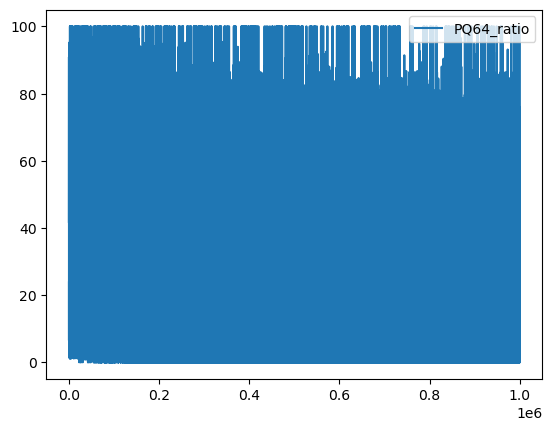

In [461]:
# Show the blue scores corresponding to the top 1M pairs by PQ64 ratio margin (used by Seamless)
plot_results(1, 1_000_000, ['ratio'], ['PQ64'])

# Blue scores are a noisy metric:

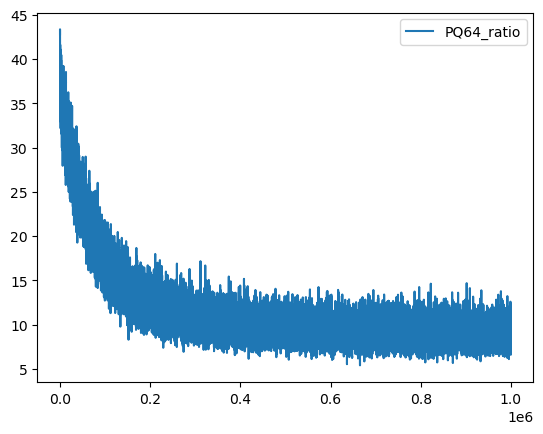

In [462]:
# Same as above, but smooth the blue scores by using a rolling window of 100.
plot_results(100, 1_000_000, ['ratio'], ['PQ64'])

# the higher the PQ64 ratio margin, the higher the average blue score, as we expected
# this means there's a correlation between higher margins and the quality of the bitext

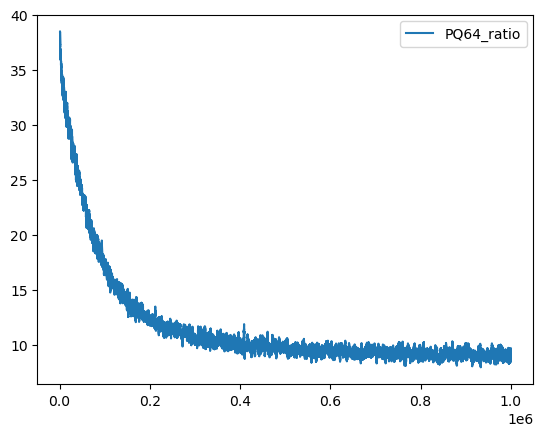

In [463]:
# same as above, but smooth the blue scores by using a rolling window of 1000
plot_results(1000, 1_000_000, ['ratio'], ['PQ64'])

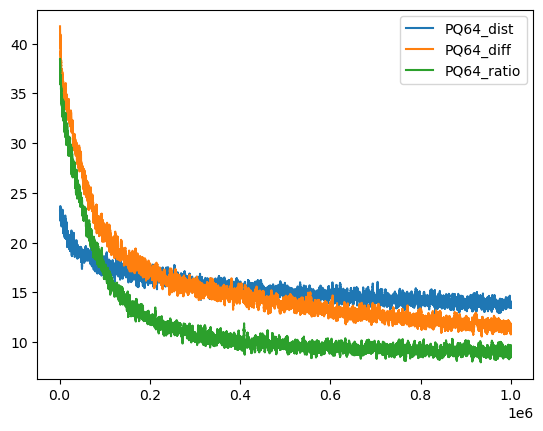

In [464]:
# Compare PQ64 margins: pure embedding distance (AKA absolute) vs ratio (the one used for Seamless mining) vs difference (of the nearest neighbor and the k nearest)
plot_results(1000, 1_000_000, ['dist', 'diff', 'ratio'], ['PQ64'])

# Note that this was a smaller scale mining job, only using 50M English sentences. This means that the scores of the highest ranked sentences matters the most, since
# we'd only use (at most) around 100K pairs from this batch when the English dataset was scaled up to 4B.

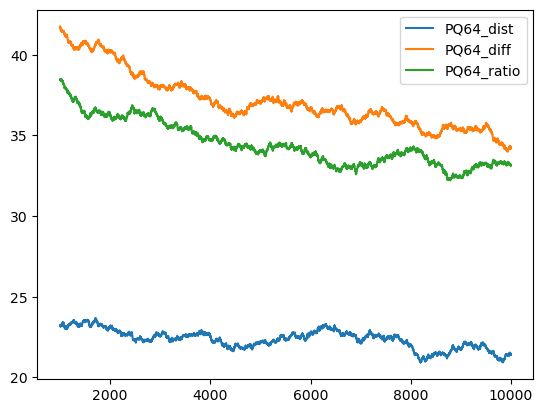

In [465]:
# Same as above, but zoom in on the top 10K only.
plot_results(1000, 10_000, ['dist', 'diff', 'ratio'], ['PQ64'])

# Difference margin blue scores are higher than ratio and both are higher than using the embedding distance (absolute) alone.

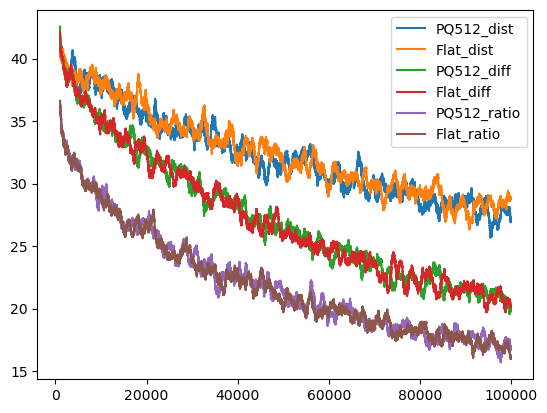

In [468]:
# Let's switch to PQ512, first see if there's any difference between Flat and PQ512
# using a rolling window of 1000 for the first 100K highest ranked by each.
plot_results(1000, 100_000, ['dist', 'diff', 'ratio'], ['PQ512', 'Flat'])

# Flat and PQ512 are close enough, so I will ignore the Flat results for the remainder.

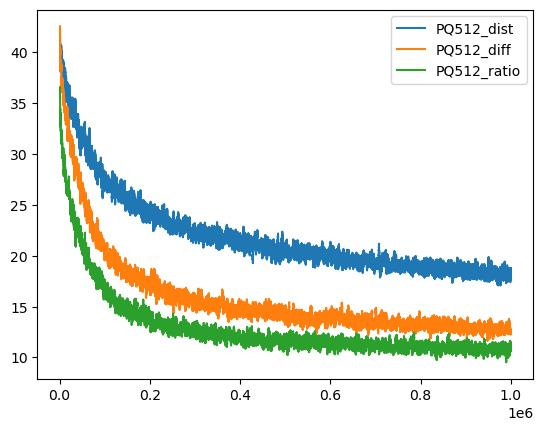

In [471]:
# PQ512 only, top 100K
plot_results(1000, 100_000, ['dist', 'diff', 'ratio'], ['PQ512'])

# For PQ512, using the distance embedding distance alone (AKA absolute margin) has the highest bleu scores.
# Compare it to the chart for PQ64, where diff > ratio > dist.

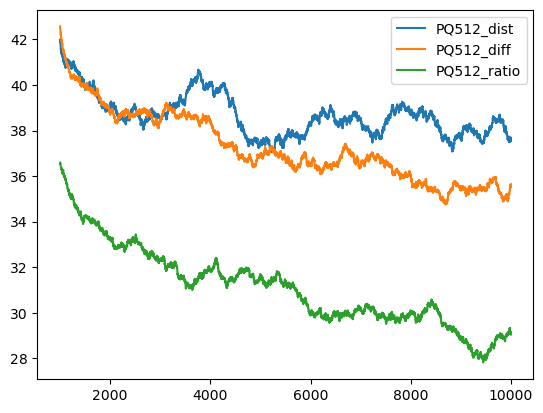

In [474]:
# PQ512 only, zoom in to top 10K
plot_results(1000, 10_000, ['dist', 'diff', 'ratio'], ['PQ512'])

# Conclusion is same as above, embedding distances have higher bleu than 
# using a margin (either ratio or difference):

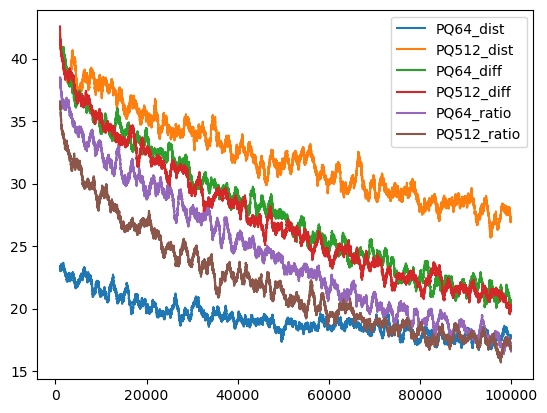

In [475]:
# PQ512 and PQ64 results on the same chart, top 100K
plot_results(1000, 100_000, ['dist', 'diff', 'ratio'], ['PQ64', 'PQ512'])

# PQ512 using embedding distance alone has the highest bleu scores,
# higher than PQ64 ratio (the one used for Seamless mining)
# PQ512 ratio gets lower scores than PQ64 ratio(!!)
# diff margins (either PQ512 or PQ64) get higher scores than the ratio
# scores for PQ64, PQ512

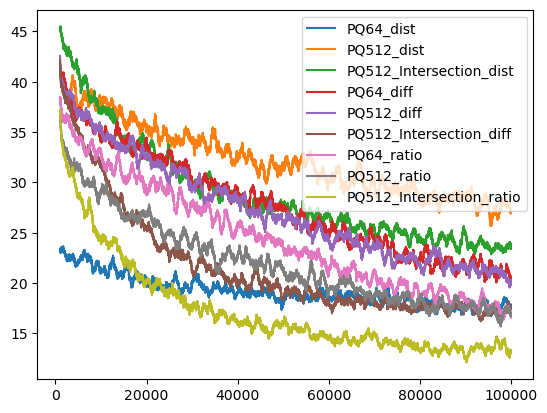

In [485]:
# So far all the scores shown were for Union of the two mining directions.
# PQ64 is too inaccurate for Intersection, even if the nearest neighbor
# of a sentence is also the nearest neighor in the opposite direction,
# due to the inaccuracy of PQ64 these pairs are often not identified correctly.
# However, PQ512 is accurate enough to find these pairs, so we can
# evaluate how PQ512 with Intersection compares to the other forms
# of mining
plot_results(1000, 100_000, ['dist', 'diff', 'ratio'], ['PQ64', 'PQ512', 'PQ512_Intersection'])

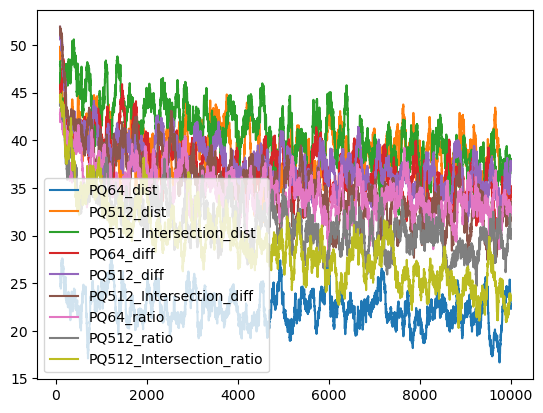

In [486]:
# Zoom in on the top 10K, reducing rolling window to 100
plot_results(100, 10_000, ['dist', 'diff', 'ratio'], ['PQ64', 'PQ512', 'PQ512_Intersection'])

# Bitext ranked highest with PQ512 distances (AKA absolute margin) using
# Intersection (vs Union) have the highest bleu scores

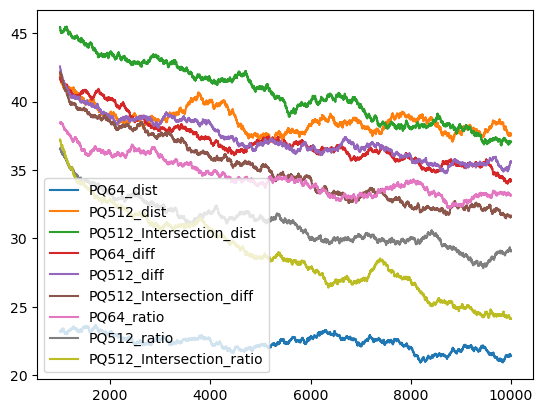

In [487]:
# With rolling window=1000 again
plot_results(1000, 10_000, ['dist', 'diff', 'ratio'], ['PQ64', 'PQ512', 'PQ512_Intersection'])

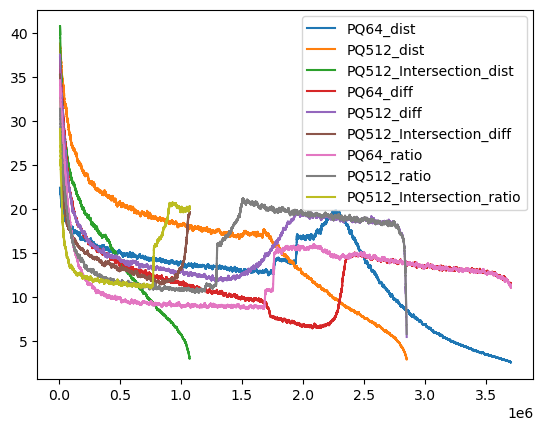

In [489]:
# Finally, a chart showing all of the above, but ranking all the mined text,
# taking a union of the top 1M ranked bitext from all minnig approaches
plot_results(10000, 5_000_000, ['dist', 'diff', 'ratio'], ['PQ64', 'PQ512', 'PQ512_Intersection'])

# The ranking with PQ512 distances and diff margin (Union or Intersection) is the most correlated with bleu scores.
# All other rankings have a spike after 1M, indicating that bitext examples that they ranked lower have higher bleu scores.

In [ ]:
window = 10000
for m in ['dist']: #, 'ratio', 'diff']:
    #plt.plot(bitext_PQ64.sort_values(m, ascending=False).reset_index(drop=True)['bleu'].rolling(window).mean(), label=f'PQ64_{m}')
    plt.plot(bitext_PQ512.sort_values(m, ascending=False).reset_index(drop=True)['bleu'].rolling(window).mean(), label=f"Union512_{m}")
    plt.plot(bitext_PQ512[bitext_PQ512['dir'] == 'both'].sort_values(m, ascending=False).reset_index(drop=True)['bleu'].rolling(window).mean(), label=f"Intersection512_{m}")
    plt.plot(bitext_Flat.sort_values(m, ascending=False).reset_index(drop=True)['bleu'].rolling(window).mean(), label=f"Union_{m}")
    plt.plot(bitext_Flat[bitext_Flat['dir'] == 'both'].sort_values(m, ascending=False).reset_index(drop=True)['bleu'].rolling(window).mean(), label=f"Intersection_{m}")
plt.legend()

In [ ]:
window = 10000
top = 100_000
for m in ['dist', 'ratio']: #, 'diff']: #['ratio']
    plt.plot(bitext_PQ512[bitext_PQ512['dir'] == 'both'].sort_values(m, ascending=False).reset_index(drop=True).head(top)['bleu'].rolling(window).mean(), label=f'PQ512_{m}')
    # plt.plot(bitext_Flat.sort_values(m, ascending=False).reset_index(drop=True).head(top)['bleu'].rolling(window).mean(), label=f"Union_{m}")
    plt.plot(bitext_Flat[bitext_Flat['dir'] == 'both'].sort_values(m, ascending=False).reset_index(drop=True).head(top)['bleu'].rolling(window).mean(), label=f"Intersection_{m}")
plt.legend()

In [188]:
bitext_Flat[bitext_Flat['bleu'] == 0.0].shape

(45377, 12)

In [187]:
bitext_PQ64[bitext_PQ64['bleu'] == 0.0].shape

(211101, 12)

In [186]:
bitext_Flat[bitext_Flat['bleu'] >= 0.0]['fin'].str.len().mean()

59.51142783036854

In [185]:
bitext_PQ64[bitext_PQ64['bleu'] >= 0.0]['fin'].str.len().mean()

65.79466130079231

In [195]:
bitext_Flat.sort_values('dist', ascending=False).reset_index(drop=True).head(70000)['bleu'].rolling(2000).mean()

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
69995    29.916997
69996    29.909182
69997    29.887710
69998    29.912712
69999    29.903065
Name: bleu, Length: 70000, dtype: float64

In [198]:
bitext_Flat.sort_values('dist', ascending=False).reset_index(drop=True)

,fin,eng,dist,ratio,diff,avg1,avg2,maxavg,avgavg,dir,eng_translated,bleu
0,"6:33 Sillä Jumalan leipä on se, joka taivaasta...",6:33 For the bread of God is He who comes down...,0.961274,1.289402,0.215755,0.745519,0.668924,0.745519,0.707221,both,6:33 For the bread of God is he who comes down...,70.453076
1,"6:44 Ei kukaan voi tulla minun tyköni, ellei I...",6:44 No one can come to me unless the Father w...,0.960352,1.105966,0.092014,0.868338,0.581053,0.868338,0.724696,both,"6:44 No man can come to me, except the Father ...",38.945861
2,"5Ja valkeus loistaa pimeydessä, ja pimeys ei s...","5And the light shines in the darkness, and the...",0.960176,1.211500,0.167625,0.792551,0.765095,0.792551,0.778823,both,"5 And the light is shining in the darkness, bu...",32.135335
3,6:29 Kuitenkin minä sanon teille: ei Salomo ka...,"6:29 And yet I say unto you, That even Solomon...",0.959728,1.264904,0.200992,0.758736,0.584051,0.758736,0.671393,both,6:29 yet I say to you that not even Solomon in...,44.306865
4,"6:29 Kuitenkin sanon minä teille, ettei Salomo...","6:29 And yet I say unto you, That even Solomon...",0.959383,1.264449,0.200647,0.758736,0.583325,0.758736,0.671030,backward,6:29 yet I say to you that not even Solomon in...,44.306865
...,...,...,...,...,...,...,...,...,...,...,...,...
2837629,"Courtney kertoo, miksi jotkut tiedemiehet usko...",Mora accompanies some of the kids who tell abo...,0.253783,1.133777,0.029944,0.223838,0.221549,0.223838,0.222694,forward,Courtney explains why some scientists believe ...,2.608346
2837630,"Heinä palaa hyvin kesällä, kuten eräs vankien ...","The item was traced to the 1960s, and validate...",0.252659,1.143220,0.031652,0.221006,0.217622,0.221006,0.219314,backward,"Hay burns well in summer, as one Toulouse chai...",1.493370
2837631,"""Oletko aivan varma, että olet hereillä juuri ...","""He who says that the person is formed at birt...",0.252575,1.127670,0.028595,0.218296,0.223980,0.223980,0.221138,both,"""Are you absolutely sure that you are awake ri...",1.347176
2837632,26: 25. Mutta kaiken tämmöisen (urhoollisuuden...,"The church, that realm of Passover (salvation)...",0.251988,1.128889,0.028770,0.223218,0.222030,0.223218,0.222624,both,26:25 But all such things (audacity) must peri...,1.987333


In [201]:
bitext_PQ64.sort_values('ratio', ascending=False).reset_index(drop=True).head(300000)['bleu'].rolling(2000).mean()

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
            ...    
299995    10.478992
299996    10.471600
299997    10.458939
299998    10.456435
299999    10.462540
Name: bleu, Length: 300000, dtype: float64

In [200]:
bitext_PQ64.sort_values('ratio', ascending=False).reset_index(drop=True).head(300000)

,fin,eng,dist,ratio,diff,avg1,avg2,maxavg,avgavg,dir,eng_translated,bleu
0,Babushkino-lajikkeen kuvauksen pitäisi alkaa s...,The description of the variety Babushkino shou...,0.372877,2.333825,0.213106,0.159771,0.158437,0.159771,0.159104,both,The description of the Babushkino variety shou...,41.816927
1,"Boba Fett, toinen klooni oli palkattu johtaama...","Boba Fett, yet another clone, had been hired t...",0.363745,2.320328,0.206981,0.151300,0.156765,0.156765,0.154032,both,"Boba Fett, another clone, had been hired to le...",48.773413
2,Addie (Tatum O'Neal) on tupakoiva 9-vuotias or...,"Addie (Tatum O'Neal) is a cigarette-smoking, n...",0.395993,2.296379,0.223551,0.172442,0.166273,0.172442,0.169357,both,Addie (Tatum O'Neal) is a 9-year-old smoking o...,47.997786
3,"Antaakseni vain muutamia esimerkkejä, Zeuksen ...","To give but a few examples, Zeus (the ""father""...",0.356411,2.266565,0.199164,0.155859,0.157247,0.157247,0.156553,both,"To give just a few examples, Zeus (the ""father...",79.580192
4,Hän ei enää juutalaiset kohtalon joka odottaa ...,He no longer wants to Jews subjected to the fa...,0.331665,2.247214,0.184076,0.147589,0.141825,0.147589,0.144707,both,He no longer has the Jews' fate that awaits th...,30.885311
...,...,...,...,...,...,...,...,...,...,...,...,...
299995,2004: Silloinen ulkoministeri Colin Powell ker...,"In February 2003, then US secretary of state C...",0.221510,1.149140,0.028748,0.183642,0.192761,0.192761,0.188202,forward,2004: Then-Secretary of State Colin Powell tol...,3.156862
299996,"6 Ja muutama lankesi kivistöön, ja kuin se tul...","Some fell on rocky places, where it didn't hav...",0.317621,1.149140,0.041222,0.276399,0.227890,0.276399,0.252144,backward,"6 And some fell upon the rocky ground, and whe...",1.981930
299997,Elefthérios Venizélos -lentokenttä,How to get to Periscope from Elefthérios Veniz...,0.337954,1.149140,0.043861,0.287926,0.294093,0.294093,0.291009,forward,The Commission notes that the airport services...,0.000000
299998,"Edelleen, yli sata vuotta partioliikkeen perus...","""After all, for 100 years, the Girl Scouts has...",0.206552,1.149140,0.026807,0.172373,0.179745,0.179745,0.176059,backward,"Still, more than a century after the Boy Scout...",3.039975


In [208]:
bitext_Flat[bitext_Flat['dir'] == 'both'].sort_values(m, ascending=False).reset_index(drop=True).head(500_000)['bleu'].rolling(window).mean()

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
            ...    
499995    11.620270
499996    11.638513
499997    11.637148
499998    11.641777
499999    11.641768
Name: bleu, Length: 500000, dtype: float64

In [221]:
bitext_Flat[(bitext_Flat['dir'] == 'both') & (bitext_Flat['dist'] > 0.79)].sort_values('dist', ascending=False).reset_index(drop=True)

,fin,eng,dist,ratio,diff,avg1,avg2,maxavg,avgavg,dir,eng_translated,bleu
0,"6:33 Sillä Jumalan leipä on se, joka taivaasta...",6:33 For the bread of God is He who comes down...,0.961274,1.289402,0.215755,0.745519,0.668924,0.745519,0.707221,both,6:33 For the bread of God is he who comes down...,70.453076
1,"6:44 Ei kukaan voi tulla minun tyköni, ellei I...",6:44 No one can come to me unless the Father w...,0.960352,1.105966,0.092014,0.868338,0.581053,0.868338,0.724696,both,"6:44 No man can come to me, except the Father ...",38.945861
2,"5Ja valkeus loistaa pimeydessä, ja pimeys ei s...","5And the light shines in the darkness, and the...",0.960176,1.211500,0.167625,0.792551,0.765095,0.792551,0.778823,both,"5 And the light is shining in the darkness, bu...",32.135335
3,6:29 Kuitenkin minä sanon teille: ei Salomo ka...,"6:29 And yet I say unto you, That even Solomon...",0.959728,1.264904,0.200992,0.758736,0.584051,0.758736,0.671393,both,6:29 yet I say to you that not even Solomon in...,44.306865
4,"14:29 Ja nyt minä olen sanonut sen teille, enn...","14:29 I have told you now before it happens, s...",0.959064,1.104719,0.090912,0.868152,0.562882,0.868152,0.715517,both,14:29 And now I have told you before it happen...,42.976150
...,...,...,...,...,...,...,...,...,...,...,...,...
108043,Halkaise avocado ja leikkaa pikkukuutioiksi.,Peel the avocados and cut into small pieces.,0.790001,1.142648,0.098624,0.691377,0.653566,0.691377,0.672472,both,Slice the avocado and cut into small cubes.,33.031643
108044,Hankala sanoa näkemättä.,I know it is hard to tell without seeing it.,0.790001,1.117409,0.083008,0.677501,0.706993,0.706993,0.692247,both,It's hard to tell without seeing it.,57.067458
108045,... kannattaisi tehdä jotakin ...,We ought to do something ...,0.790001,1.082703,0.060345,0.729656,0.641148,0.729656,0.685402,both,... you should do something...,40.261910
108046,Angelina Joliella ja Brad Pittillä on yhteensä...,● Angelina Jolie and Brad Pitt have six children.,0.790000,1.276826,0.171278,0.618722,0.595139,0.618722,0.606930,both,Angelina Jolie and Brad Pitt have six children...,78.254229


In [247]:
stopes_intersect_absolute = pd.read_csv('/checkpoint/gsz/seamless/PQ512_intersect_absolute_eng0_fin.tsv', sep='\t', header=None)
stopes_intersect_absolute.shape

(3510941, 3)

In [248]:
stopes_intersect_absolute

,0,1,2
0,1.943102,The company has delivered solutions for many o...,Yhtiö on toimittanut ratkaisuja monille maailm...
1,1.936166,This includes all major sports channels such a...,Tämä sisältää kaikki tärkeimmät urheilukanavat...
2,1.934723,"15:27 You will also testify, because you have ...","15:27 Ja te myös todistatte, sillä te olette a..."
3,1.933905,"Compatible with audio formats such as AAC, AC3...","Yhteensopiva ääniformaatteja kuten AAC, AC3, O..."
4,1.932370,This summary is based on the products: G1 Jock...,Tämä yhteenveto perustuu tuotteisiin: G1 Jocke...
...,...,...,...
3510936,1.600000,Work closely with the schools.,Siinä yhteistyötä tehtiin tiiviisti koulujen k...
3510937,1.600000,Just the same from start to finish.,Samaa duunia se on alusta loppuun.
3510938,1.600000,"Suddenly, from the distance, a yell comes.",Yhtäkkiä jostain kaukaisuudesta kuului närkäst...
3510939,1.600000,Photographs are a visual medium.,Valokuvat ovat visuaalinen juttu.


In [249]:
bitext_PQ512

,fin,eng,dist,ratio,diff,avg1,avg2,maxavg,avgavg,dir,eng_translated,bleu
0,"6:33 Sillä Jumalan leipä on se, joka taivaasta...",6:33 For the bread of God is He who comes down...,0.952005,1.294108,0.216359,0.735646,0.658637,0.735646,0.697142,both,6:33 For the bread of God is he who comes down...,70.453076
1,"6:33 Sillä Jumalan leipä on se, joka taivaasta...",Jhn6:33 The bread of God is the bread which co...,0.873339,1.217264,0.155879,0.717461,0.658637,0.717461,0.688049,forward,6:33 For the bread of God is he who comes down...,47.267042
2,"6:33 Sillä Jumalan leipä on se, joka taivaasta...",For THE BREAD that GOD gives is HE WHO comes d...,0.828026,1.252459,0.166906,0.661120,0.658637,0.661120,0.659879,forward,6:33 For the bread of God is he who comes down...,33.932908
3,"6:33 Sillä Jumalan leipä on se, joka taivaasta...","""For the bread of God is he who comes down fro...",0.807468,1.225967,0.148831,0.645251,0.658637,0.658637,0.651944,forward,6:33 For the bread of God is he who comes down...,73.827134
4,"6:44 Ei kukaan voi tulla minun tyköni, ellei I...",6:44 No one can come to me unless the Father w...,0.949027,1.119531,0.101326,0.847701,0.572959,0.847701,0.710330,backward,"6:44 No man can come to me, except the Father ...",38.945861
...,...,...,...,...,...,...,...,...,...,...,...,...
2848543,"""23 Kun Jumalan lapsiksi tunnustautuvat liitty...","For by sending God's own ""son"" - a participant...",0.250753,1.125924,0.028044,0.222159,0.222709,0.222709,0.222434,both,"""23 When those who profess to be children of G...",2.036086
2848544,"Benjamin pakeni ""ikuiseen uneen"": hän riisti m...","Although Matt is young, only fourteen, he has ...",0.250657,1.142943,0.031349,0.218399,0.219309,0.219309,0.218854,both,"Benjamin fled to ""eternal sleep"": he died of a...",7.113990
2848545,"Courtney kertoo, miksi jotkut tiedemiehet usko...",Mora accompanies some of the kids who tell abo...,0.249458,1.130197,0.028737,0.220721,0.218191,0.220721,0.219456,forward,Courtney explains why some scientists believe ...,2.608346
2848546,"""Välimeren maista kotoisin oleva""-ilmaisua käy...",Is it the one peopled by the Itsekiris who are...,0.248227,1.132668,0.029075,0.217015,0.219153,0.219153,0.218084,backward,"The expression ""a Mediterranean"" is almost alw...",0.710023


In [258]:
test_PQ512 = stopes_intersect_absolute.merge(bitext_PQ512, left_on=[1, 2], right_on=['eng', 'fin'])

In [259]:
test_PQ64 = stopes_intersect_absolute.merge(bitext_PQ64, left_on=[1, 2], right_on=['eng', 'fin'])

In [ ]:
top = 5000
for m in ['dist', 'ratio', 'diff']: #['ratio']
    plt.plot(bitext_PQ64.sort_values(m, ascending=False).reset_index(drop=True).head(top)['bleu'].expanding().mean(), label=f'PQ64_{m}')
    plt.plot(bitext_PQ512.sort_values(m, ascending=False).reset_index(drop=True).head(top)['bleu'].expanding().mean(), label=f'PQ512_{m}')
    #plt.plot(bitext_Flat.sort_values(m, ascending=False).reset_index(drop=True).head(top)['bleu'].rolling(window).mean(), label=f"Flat_{m}")
plt.legend()

In [345]:
test_PQ512

,0,1,2,fin,eng,dist,ratio,diff,avg1,avg2,maxavg,avgavg,dir,eng_translated,bleu
0,1.912335,6:33 For the bread of God is He who comes down...,"6:33 Sillä Jumalan leipä on se, joka taivaasta...","6:33 Sillä Jumalan leipä on se, joka taivaasta...",6:33 For the bread of God is He who comes down...,0.952005,1.294108,0.216359,0.735646,0.658637,0.735646,0.697142,both,6:33 For the bread of God is he who comes down...,70.453076
1,1.909356,"14:29 I have told you now before it happens, s...","14:29 Ja nyt minä olen sanonut sen teille, enn...","14:29 Ja nyt minä olen sanonut sen teille, enn...","14:29 I have told you now before it happens, s...",0.938933,1.103424,0.088006,0.850927,0.556060,0.850927,0.703493,both,14:29 And now I have told you before it happen...,42.976150
2,1.908828,"13:8 Jesus Christ the same yesterday, today an...",13:8 Jeesus Kristus on sama eilen ja tänään ja...,13:8 Jeesus Kristus on sama eilen ja tänään ja...,"13:8 Jesus Christ the same yesterday, today an...",0.944477,1.085657,0.074518,0.869959,0.804579,0.869959,0.837269,both,13:8 Jesus Christ is the same yesterday and to...,53.720182
3,1.908439,Mat 7:14 But small is the gate and narrow the ...,"7:14 Ja se portti on ahdas, ja tie kaita, joka...","7:14 Ja se portti on ahdas, ja tie kaita, joka...",Mat 7:14 But small is the gate and narrow the ...,0.948695,1.082649,0.072423,0.876273,0.752620,0.876273,0.814446,backward,7:14 And narrow is the gate and cramped the ro...,48.501132
4,1.906269,"30 I will no longer talk much with you, for th...","30 En minä enää puhu paljoa teidän kanssanne, ...","30 En minä enää puhu paljoa teidän kanssanne, ...","30 I will no longer talk much with you, for th...",0.941563,1.343784,0.240883,0.700680,0.428586,0.700680,0.564633,both,"30 I will no longer speak much with you, for t...",70.945211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10474,1.600139,"No, I never think of losing.",- Emme koskaan ajattele häviämistä.,- Emme koskaan ajattele häviämistä.,"No, I never think of losing.",0.791741,1.178713,0.120042,0.671700,0.640227,0.671700,0.655963,both,We never think about losing.,15.619700
10475,1.600103,(one male and one female),1 poika ja 1 tyttö),1 poika ja 1 tyttö),(one male and one female),0.806141,1.117719,0.084904,0.721237,0.665050,0.721237,0.693143,both,1 male and 1 female),18.575058
10476,1.600077,"""We are thrilled about this transaction.","""Olemme innoissamme tästä kaupasta.","""Olemme innoissamme tästä kaupasta.","""We are thrilled about this transaction.",0.788314,1.094743,0.068223,0.720091,0.683180,0.720091,0.701635,both,"""We are very excited about this deal.",23.875171
10477,1.600024,I'm just wondering if I'm weird.,Eli mietin tässä olenko jotenkin outo.,Eli mietin tässä olenko jotenkin outo.,I'm just wondering if I'm weird.,0.789832,1.103273,0.073933,0.715899,0.642447,0.715899,0.679173,both,So I'm wondering if I'm being weird.,27.890014


In [364]:
top = 10000
series_512 = bitext_PQ512[(bitext_PQ512['dir']=='both') & (bitext_PQ512['diff'] > 0.1)].sort_values('dist', ascending=False).reset_index(drop=True).head(top)['bleu']
series_64 = bitext_PQ64.sort_values('ratio', ascending=False).reset_index(drop=True).head(top)['bleu']

In [365]:
step = 5
_, division_64 = np.histogram(series_64, np.arange(0, 100+step, step))
_, division_512 = np.histogram(series_512, np.arange(0, 100+step, step))

<AxesSubplot: >

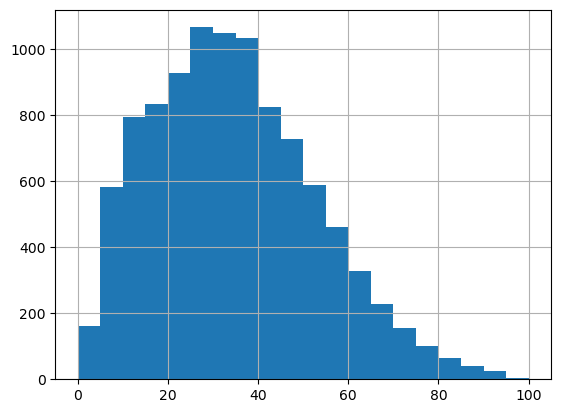

In [338]:
series_64.hist(bins=division_64)

In [329]:
series_64.median()

32.93260800218654

<AxesSubplot: >

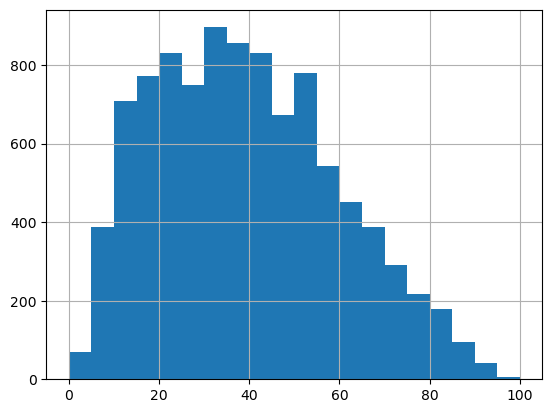

In [367]:
series_512.hist(bins=division_512)

In [366]:
series_512.median()

38.260294162784454

In [353]:
bitext_PQ512[bitext_PQ512['bleu'] > 90]

,fin,eng,dist,ratio,diff,avg1,avg2,maxavg,avgavg,dir,eng_translated,bleu
20,11 tuntia ja 43 minuuttia.,11 hours and 43 minutes.,0.943582,1.086624,0.075221,0.868360,0.733506,0.868360,0.800933,both,11 hours and 43 minutes.,100.000000
33,19 tuntia ja 17 minuuttia.,19 hours and 17 minutes.,0.941067,1.076033,0.066496,0.874571,0.717310,0.874571,0.795941,both,19 hours and 17 minutes.,100.000000
48,22 tuntia ja 31 minuuttia.,22 hours and 31 minutes.,0.939183,1.081489,0.070766,0.868417,0.689702,0.868417,0.779059,both,22 hours and 31 minutes.,100.000000
49,11 tuntia ja 37 minuuttia.,11 hours and 37 minutes.,0.939159,1.084755,0.073379,0.865780,0.737012,0.865780,0.801396,both,11 hours and 37 minutes.,100.000000
98,1 tuntia ja 25 minuuttia,1 hour and 25 minutes,0.935242,1.089816,0.077077,0.858165,0.751547,0.858165,0.804856,both,1 hour and 25 minutes,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022535,Bigbankin pankkijärjestelmä yksi maailman parh...,Our banking system is one of the best in the w...,0.618979,1.168228,0.089135,0.529844,0.494344,0.529844,0.512094,both,Bigbank's banking system is one of the best in...,90.360200
2042272,"He vastaavat: ""Viivyimme kai päivän tai osansi...","They will say: "" We stayed a day or part of a ...",0.613919,1.155749,0.082732,0.531188,0.503549,0.531188,0.517369,backward,"They will say: ""We stayed a day or part of a day.",100.000000
2148403,Anna Puu - We're not gonna take it (Twisted Si...,We're not gonna take it (Twisted Sister),0.586016,1.153127,0.077819,0.508198,0.425978,0.508198,0.467088,both,We're not gonna take it (Twisted Sister),100.000000
2177747,Brodeuria pidetään yleisesti yhtenä kaikkien a...,Schmeichel is widely regarded as one of the gr...,0.578047,1.168009,0.083148,0.490603,0.494900,0.494900,0.492751,both,Brodeur is widely regarded as one of the great...,91.932272


In [351]:
bitext_PQ512

,fin,eng,dist,ratio,diff,avg1,avg2,maxavg,avgavg,dir,eng_translated,bleu
0,"6:33 Sillä Jumalan leipä on se, joka taivaasta...",6:33 For the bread of God is He who comes down...,0.952005,1.294108,0.216359,0.735646,0.658637,0.735646,0.697142,both,6:33 For the bread of God is he who comes down...,70.453076
1,"6:33 Sillä Jumalan leipä on se, joka taivaasta...",Jhn6:33 The bread of God is the bread which co...,0.873339,1.217264,0.155879,0.717461,0.658637,0.717461,0.688049,forward,6:33 For the bread of God is he who comes down...,47.267042
2,"6:33 Sillä Jumalan leipä on se, joka taivaasta...",For THE BREAD that GOD gives is HE WHO comes d...,0.828026,1.252459,0.166906,0.661120,0.658637,0.661120,0.659879,forward,6:33 For the bread of God is he who comes down...,33.932908
3,"6:33 Sillä Jumalan leipä on se, joka taivaasta...","""For the bread of God is he who comes down fro...",0.807468,1.225967,0.148831,0.645251,0.658637,0.658637,0.651944,forward,6:33 For the bread of God is he who comes down...,73.827134
4,"6:44 Ei kukaan voi tulla minun tyköni, ellei I...",6:44 No one can come to me unless the Father w...,0.949027,1.119531,0.101326,0.847701,0.572959,0.847701,0.710330,backward,"6:44 No man can come to me, except the Father ...",38.945861
...,...,...,...,...,...,...,...,...,...,...,...,...
2848543,"""23 Kun Jumalan lapsiksi tunnustautuvat liitty...","For by sending God's own ""son"" - a participant...",0.250753,1.125924,0.028044,0.222159,0.222709,0.222709,0.222434,both,"""23 When those who profess to be children of G...",2.036086
2848544,"Benjamin pakeni ""ikuiseen uneen"": hän riisti m...","Although Matt is young, only fourteen, he has ...",0.250657,1.142943,0.031349,0.218399,0.219309,0.219309,0.218854,both,"Benjamin fled to ""eternal sleep"": he died of a...",7.113990
2848545,"Courtney kertoo, miksi jotkut tiedemiehet usko...",Mora accompanies some of the kids who tell abo...,0.249458,1.130197,0.028737,0.220721,0.218191,0.220721,0.219456,forward,Courtney explains why some scientists believe ...,2.608346
2848546,"""Välimeren maista kotoisin oleva""-ilmaisua käy...",Is it the one peopled by the Itsekiris who are...,0.248227,1.132668,0.029075,0.217015,0.219153,0.219153,0.218084,backward,"The expression ""a Mediterranean"" is almost alw...",0.710023


In [380]:
top = 10000
series_512 = bitext_PQ512[(bitext_PQ512['dir']=='both')].sort_values('bleu', ascending=False).reset_index(drop=True).head(top)['diff']
series_64 = bitext_PQ64.sort_values('bleu', ascending=False).reset_index(drop=True).head(top)['ratio']

In [381]:
step = 0.1
_, division_64 = np.histogram(series_64, np.arange(0.0, 2.0+step, step))
_, division_512 = np.histogram(series_512, np.arange(0.0, 2.0+step, step))

<AxesSubplot: >

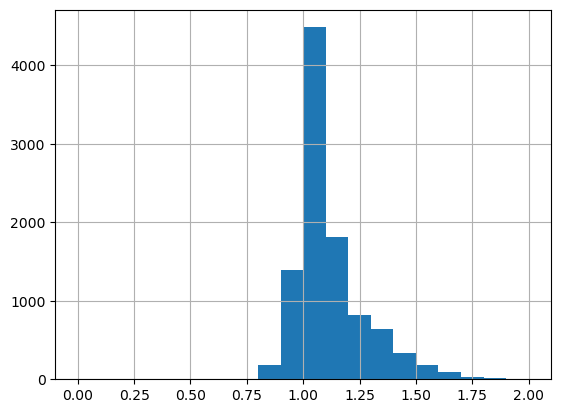

In [375]:
series_64.hist(bins=division_512)

<AxesSubplot: >

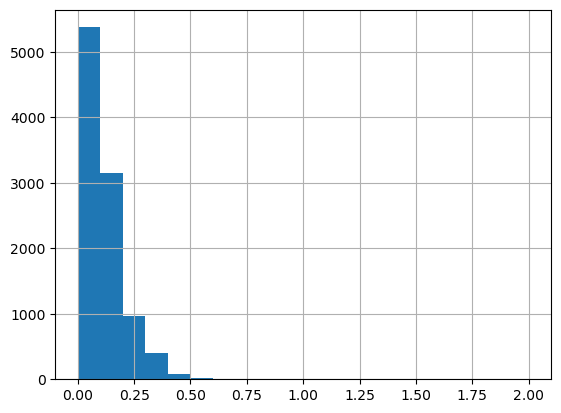

In [382]:
series_512.hist(bins=division_512)

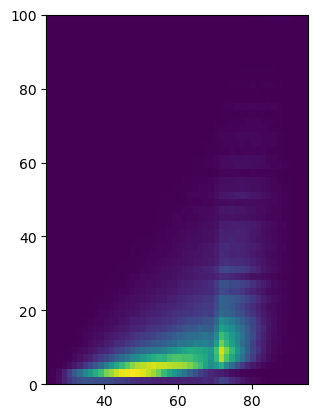

In [422]:
test = bitext_PQ512[bitext_PQ512['dir'] == 'both']
heatmap, xedges, yedges = np.histogram2d(test['dist'].to_numpy()*100, test['bleu'].to_numpy(), bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
#plt.show()

In [405]:
bitext_PQ64['ratio'].to_numpy()

array([1.0971549, 0.8506226, 1.1191324, ..., 1.0832548, 1.0684388,
       1.0712837], dtype=float32)